# Tooth Segmentation Inference

This notebook loads the pretrained U-Net model and runs inference on dental panoramic X-ray images.

**Pretrained model:** `output/models/dental_xray_seg.h5`

**Features:**
- Load and preprocess dental X-ray images
- Run U-Net segmentation
- Post-processing with Connected Component Analysis (CCA)
- Tooth counting and measurement
- **FDI tooth numbering** (automatic quadrant detection with K-Means clustering)
- **Edentulous zone detection** (missing teeth gap measurement)
- **Physical measurements (mm)** with uncertainty quantification
- **3D visualization** of panoramic X-ray projection geometry (understanding 2D↔3D registration)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Setup paths
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve()
sys.path.insert(0, str(PROJECT_ROOT))

from config import DATA_DIR, OUTPUT_DIR, PREDICTIONS_DIR, MODELS_DIR, ensure_dirs
ensure_dirs()

print(f"Project root: {PROJECT_ROOT}")
print(f"Models directory: {MODELS_DIR}")

Project root: /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net
Models directory: /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net/output/models


In [3]:
# Load pretrained model
# Note: Due to Keras version differences, we rebuild the architecture and load weights only
import tensorflow as tf
from model import UNET

MODEL_PATH = MODELS_DIR / 'dental_xray_seg.h5'
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}. Run Main.ipynb first to train.")

# Rebuild model architecture (avoids Keras version compatibility issues)
model = UNET(input_shape=(512, 512, 1), last_activation='sigmoid')

# Load weights from the saved H5 file
model.load_weights(str(MODEL_PATH))

print(f"Loaded model weights from: {MODEL_PATH}")
print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")

Loaded model weights from: /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net/output/models/dental_xray_seg.h5
Input shape: (None, 512, 512, 1)
Output shape: (None, 512, 512, 1)


In [4]:
# Helper functions for inference
import numpy as np
from PIL import Image
from utils import load_and_preprocess
import cv2

def run_inference(model, image: np.ndarray, threshold: float = 0.25) -> np.ndarray:
    """
    Run segmentation inference.
    
    Args:
        model: Loaded Keras model
        image: Preprocessed image (1, H, W, 1)
        threshold: Binarization threshold
    
    Returns:
        Binary mask (H, W)
    """
    prediction = model.predict(image, verbose=0)
    mask = prediction[0, :, :, 0]
    binary_mask = (mask > threshold).astype(np.uint8) * 255
    return mask, binary_mask


print("Helper functions loaded.")

Helper functions loaded.


## Single Image Inference

Select an image from the dataset or provide your own path.

In [5]:
# List available images
from natsort import natsorted

IMAGES_DIR = DATA_DIR / 'Images'
available_images = natsorted(list(IMAGES_DIR.glob('*.png')))
print(f"Found {len(available_images)} images in {IMAGES_DIR}")
print(f"\nFirst 10 images:")
for img in available_images[:10]:
    print(f"  - {img.name}")

Found 116 images in /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net/data/Images

First 10 images:
  - 1.png
  - 2.png
  - 3.png
  - 4.png
  - 5.png
  - 6.png
  - 7.png
  - 8.png
  - 9.png
  - 10.png


In [6]:
# Select image for inference
# Change this to test different images
IMAGE_INDEX = 107  # Test set image (indices 106-116 are test set)

image_path = IMAGES_DIR / f"{IMAGE_INDEX}.png"
if not image_path.exists():
    raise FileNotFoundError(f"Image not found: {image_path}")

print(f"Selected image: {image_path}")

Selected image: /Users/huy/src/dentalml/reference_projects/Segmentation-of-Teeth-in-Panoramic-X-ray-Image-Using-U-Net/data/Images/107.png


In [7]:
# Run inference
preprocessed, original = load_and_preprocess(image_path)
raw_prediction, binary_mask = run_inference(model, preprocessed, threshold=0.25)

print(f"Original image shape: {original.shape}")
print(f"Prediction shape: {raw_prediction.shape}")
print(f"Prediction value range: [{raw_prediction.min():.3f}, {raw_prediction.max():.3f}]")

Original image shape: (1300, 3126)
Prediction shape: (512, 512)
Prediction value range: [0.000, 1.000]


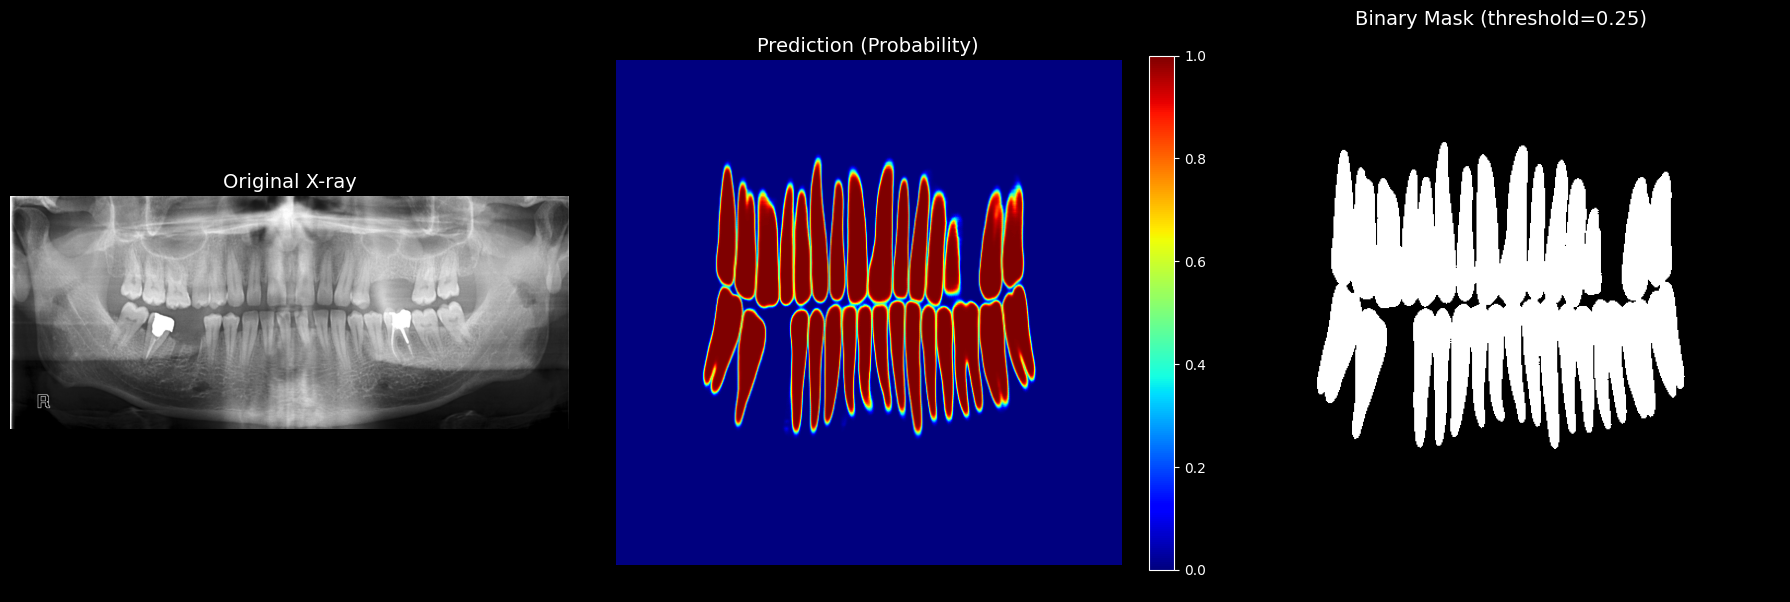

In [8]:
from utils import visualize_prediction

visualize_prediction(original, raw_prediction, binary_mask)

## Overlay Visualization

Overlay segmentation contours on the original image.

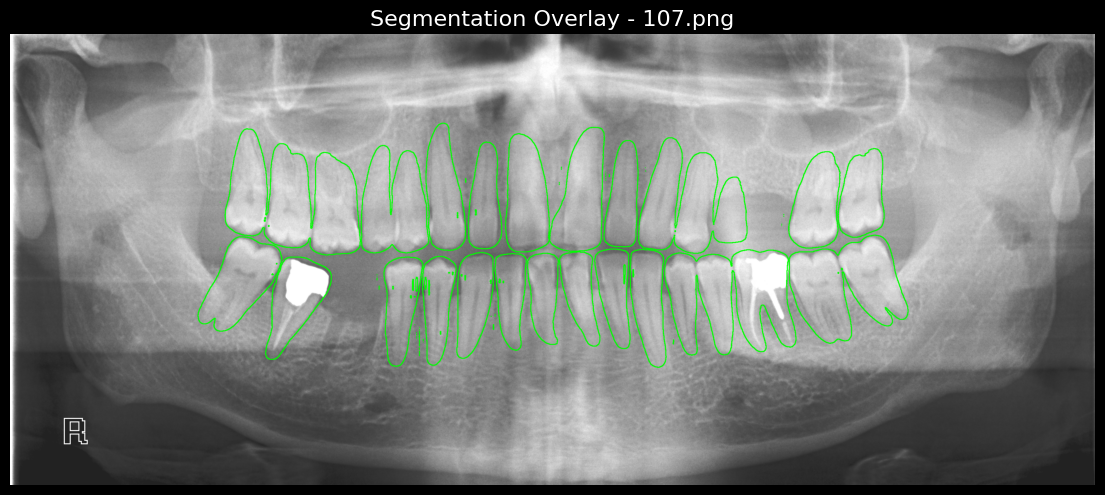

In [20]:
import matplotlib.pyplot as plt
prediction_resized = cv2.resize(raw_prediction, (original.shape[1], original.shape[0]),
                                interpolation=cv2.INTER_LANCZOS4)

# Create binary mask at original resolution
mask_uint8 = np.uint8(prediction_resized * 255)
_, mask_binary = cv2.threshold(mask_uint8, thresh=255 // 2, maxval=255, type=cv2.THRESH_BINARY)

# Find and draw contours
contours, _ = cv2.findContours(mask_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create overlay image
if len(original.shape) == 2:
    overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
else:
    overlay = original.copy()

cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)

# Display
plt.figure(figsize=(14, 10))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f'Segmentation Overlay - {image_path.name}', fontsize=16)
plt.axis('off')
plt.show()

## Connected Component Analysis (CCA)

Post-processing to count teeth and measure dimensions.

In [13]:
from CCA_Analysis import CCA_Analysis

# Load original image in BGR format for CCA
img_bgr = cv2.imread(str(image_path))

# Prepare prediction for CCA (needs to be BGR format)
prediction_bgr = cv2.cvtColor(mask_uint8, cv2.COLOR_GRAY2BGR)
prediction_bgr = cv2.resize(prediction_bgr, (img_bgr.shape[1], img_bgr.shape[0]))

# Run CCA analysis
# erode_iteration: higher = more separation between teeth
# open_iteration: higher = less noise
cca_result, teeth_count = CCA_Analysis(
    orig_image=img_bgr.copy(),
    predict_image=prediction_bgr,
    erode_iteration=3,
    open_iteration=2
)

print(f"Detected teeth count: {teeth_count}")

Detected teeth count: 29


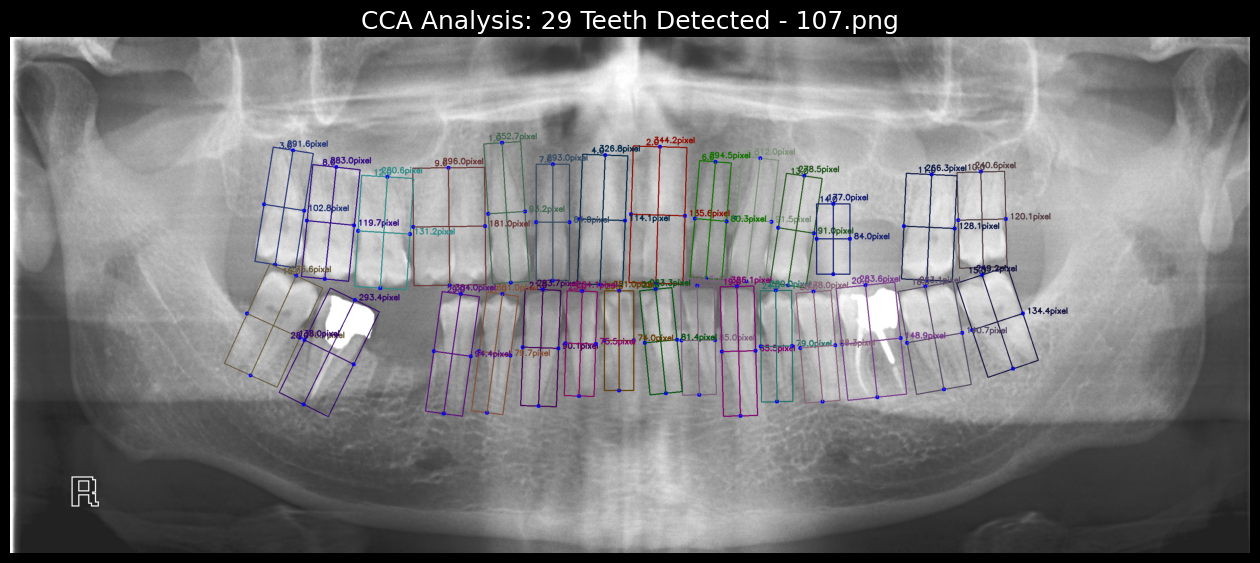

In [14]:
# Display CCA result
from matplotlib import pyplot as plt
plt.figure(figsize=(16, 12))
plt.imshow(cv2.cvtColor(cca_result, cv2.COLOR_BGR2RGB))
plt.title(f'CCA Analysis: {teeth_count} Teeth Detected - {image_path.name}', fontsize=18)
plt.axis('off')
plt.show()

## Edentulous Zone Analysis with FDI Numbering

Detect missing teeth zones and assign FDI (Fédération Dentaire Internationale) numbers to each detected tooth.

**Features:**
- Automatic arch separation (upper/lower) using K-Means clustering
- Quadrant assignment (Q1-Q4) based on tooth position
- FDI numbering (11-18, 21-28, 31-38, 41-48)
- Gap detection between adjacent teeth
- Edentulous zone measurement (width, height, area in pixels)

In [ ]:
# Import the tooth analysis module
from tooth_analysis import (
    analyze_dental_panorama,
    visualize_analysis,
    print_analysis_report
)

# Run the full dental analysis on the prediction
# prediction_bgr is already prepared from the CCA section above
analysis_result = analyze_dental_panorama(
    prediction_mask=prediction_bgr,
    image_shape=img_bgr.shape[:2],
    erode_iterations=3,
    open_iterations=2,
    min_tooth_area=2000,
    gap_threshold=2,
)

print(f"Analysis complete!")
print(f"Detected teeth: {analysis_result.total_detected}")
print(f"Missing teeth: {analysis_result.total_missing}")
print(f"Reference count: {analysis_result.reference_count}")

In [ ]:
# Visualize the analysis with FDI labels and edentulous zones
analysis_viz = visualize_analysis(
    original_image=img_bgr,
    result=analysis_result,
    show_fdi_labels=True,
    show_zones=True,
    show_measurements=True
)

# Display
plt.figure(figsize=(18, 12))
plt.imshow(cv2.cvtColor(analysis_viz, cv2.COLOR_BGR2RGB))
plt.title(f'FDI Numbering & Edentulous Zones - {image_path.name}', fontsize=18)
plt.axis('off')
plt.show()

In [ ]:
# Print detailed analysis report
_ = print_analysis_report(analysis_result)

In [ ]:
import pandas as pd
# Show detected teeth details by quadrant
teeth_data = []
for tooth in sorted(analysis_result.detected_teeth, key=lambda t: t.fdi_number or 0):
    teeth_data.append({
        'FDI': tooth.fdi_number,
        'Quadrant': tooth.quadrant,
        'Centroid X': int(tooth.centroid[0]),
        'Centroid Y': int(tooth.centroid[1]),
        'Width': int(tooth.width),
        'Height': int(tooth.height),
        'Area': tooth.area
    })

df_teeth = pd.DataFrame(teeth_data)
print("Detected Teeth Details:")
print(df_teeth.to_string(index=False))

# Edentulous zones summary
if analysis_result.edentulous_zones:
    print("\n\nEdentulous Zones (Pixel Measurements):")
    zones_data = []
    for zone in analysis_result.edentulous_zones:
        zones_data.append({
            'Quadrant': zone.quadrant,
            'Missing FDI': str(zone.missing_fdi_numbers),
            'Width (px)': zone.bbox[2],
            'Height (px)': zone.bbox[3],
            'Area (px^2)': zone.area,
            'Missing Count': zone.missing_count
        })
    df_zones = pd.DataFrame(zones_data)
    print(df_zones.to_string(index=False))
else:
    print("\n\nNo edentulous zones detected - all teeth appear present!")

## Physical Measurements (mm)

Convert pixel measurements to physical (millimeter) measurements using calibration priors.

**IMPORTANT LIMITATIONS:**
- Panoramic radiography has spatially-varying magnification (15-30%)
- Horizontal measurements are LESS reliable than vertical
- Anterior region has HIGHEST uncertainty
- For clinical decisions requiring <1mm precision, use CBCT

**Calibration Methods (in order of accuracy):**
1. **Calibration ball**: Place 5-6mm metal ball in region of interest (GOLD STANDARD)
2. **Reference tooth**: Use known tooth width as reference
3. **Assumed FOV**: Estimate from image dimensions and typical X800 FOV (~270mm)

### Method 1: Priors from the image

In [17]:
# Import physical metrics module
from physical_metrics import (
    create_priors_from_image_dimensions,
    create_priors_from_reference_tooth,
    print_physical_measurement_report,
    DentalRegion,
)
from tooth_analysis import convert_zones_to_physical, visualize_analysis_physical

# Get original image dimensions
original_height, original_width = original.shape[:2]
print(f"Original image dimensions: {original_width} x {original_height} px")

# Method 1: Create priors from assumed FOV (least accurate, but works without calibration)
# X800 panoramic FOV is approximately 240-300mm wide
# Using 270mm as typical value
priors_fov = create_priors_from_image_dimensions(
    image_width_px=original_width,
    image_height_px=original_height,
    fov_width_mm=270.0,  # Typical X800 panoramic FOV
    machine="X800"
)

print(f"\nCalibration Method: {priors_fov.calibration_method}")
print(f"Pixel spacing: {priors_fov.get_effective_pixel_spacing():.4f} mm/px")
print(f"Calibrated: {priors_fov.is_calibrated()}")

Original image dimensions: 3126 x 1300 px

Calibration Method: assumed_fov
Pixel spacing: 0.0864 mm/px
Calibrated: False


In [18]:
# Convert edentulous zones to physical measurements
zones_physical = convert_zones_to_physical(analysis_result, priors_fov)

# Print detailed physical measurement report
_ = print_physical_measurement_report(zones_physical, priors_fov)

NameError: name 'analysis_result' is not defined

In [ ]:
# Visualize with physical measurements and confidence indicators
analysis_viz_physical = visualize_analysis_physical(
    original_image=img_bgr,
    result=analysis_result,
    priors=priors_fov,
    show_fdi_labels=True,
    show_zones=True,
    show_measurements=True,
    show_confidence=True,
)

# Display
plt.figure(figsize=(18, 12))
plt.imshow(cv2.cvtColor(analysis_viz_physical, cv2.COLOR_BGR2RGB))
plt.title(f'Physical Measurements (mm) with Confidence - {image_path.name}', fontsize=18)
plt.axis('off')
plt.show()


### Method 2: Priors from reference tooth

## 3D Visualization: Panoramic X-ray Projection Geometry

Understanding **why** panoramic measurements have varying reliability requires understanding the imaging geometry.

**Key concepts visualized:**
1. **Dental arch (3D)**: The teeth form a horseshoe-shaped curve in 3D space
2. **Focal trough**: The "sweet spot" where structures are in focus (varies by region)
3. **Rotating source/detector**: X-ray source rotates around the arch, creating projection
4. **Regional magnification**: Different regions (anterior/premolar/molar) have different magnifications

**Why horizontal measurements are less reliable:**
- The X-ray beam is tangent to the arch at different angles
- Anterior region: beam nearly parallel to tooth -> maximum horizontal distortion
- Molar region: beam more perpendicular -> less horizontal distortion
- Vertical measurements: relatively consistent because detector height is fixed

Below we show visualizations for **both calibration methods** to compare.

In [19]:
# === METHOD 1: FOV-based Calibration ===
# Uses assumed field-of-view (270mm typical for X800) to estimate pixel spacing
# Least accurate but works without any calibration reference

from pano_geometry_viz import (
    create_xray_geometry_animation,
    create_magnification_chart,
    create_panoramic_geometry_visualization,
    print_geometry_insights,
)

METHOD_1_LABEL = f"Method 1: FOV-based ({priors_fov.calibration_method})"
METHOD_1_SUBTITLE = f"Pixel spacing: {priors_fov.get_effective_pixel_spacing():.4f} mm/px | Calibrated: {priors_fov.is_calibrated()}"

# X-ray rotation animation (same for both methods - shows physics)
fig_rotation = create_xray_geometry_animation(title_suffix="X-ray source rotation principle")
fig_rotation.show()

# Magnification bar chart for Method 1
fig_mf_1 = create_magnification_chart(priors_fov, title_suffix=METHOD_1_SUBTITLE)
fig_mf_1.show()

# 3D->2D projection with detected teeth overlay (Method 1)
fig_geom_1 = create_panoramic_geometry_visualization(
    priors=priors_fov,
    detected_teeth=analysis_result.detected_teeth,
    edentulous_zones=analysis_result.edentulous_zones,
    image_width_px=original_width,
    image_height_px=original_height,
    title_suffix=METHOD_1_SUBTITLE,
)
fig_geom_1.show()

print(f"\n{METHOD_1_LABEL}")
print(f"  {METHOD_1_SUBTITLE}")

NameError: name 'analysis_result' is not defined

In [ ]:
# === METHOD 2: Tooth Reference Calibration ===
# Uses a detected molar tooth as reference (more accurate than FOV estimation)
# Derives pixel spacing from known average tooth widths (Wheeler's Dental Anatomy)

if 'priors_tooth_ref' in dir() and priors_tooth_ref is not None:
    METHOD_2_LABEL = f"Method 2: Tooth Reference ({priors_tooth_ref.calibration_method})"
    METHOD_2_SUBTITLE = f"Pixel spacing: {priors_tooth_ref.get_effective_pixel_spacing():.4f} mm/px | Reference: FDI {ref_tooth.fdi_number}"
    
    # Magnification bar chart for Method 2
    fig_mf_2 = create_magnification_chart(priors_tooth_ref, title_suffix=METHOD_2_SUBTITLE)
    fig_mf_2.show()
    
    # 3D->2D projection with detected teeth overlay (Method 2)
    fig_geom_2 = create_panoramic_geometry_visualization(
        priors=priors_tooth_ref,
        detected_teeth=analysis_result.detected_teeth,
        edentulous_zones=analysis_result.edentulous_zones,
        image_width_px=original_width,
        image_height_px=original_height,
        title_suffix=METHOD_2_SUBTITLE,
    )
    fig_geom_2.show()
    
    print(f"\n{METHOD_2_LABEL}")
    print(f"  {METHOD_2_SUBTITLE}")
else:
    print("Method 2 not available - no molar teeth detected for reference calibration")

# Print key insights
print_geometry_insights()

In [ ]:
# === COMPARISON: Method 1 vs Method 2 ===
# The magnification factors are the same (from X800_DEFAULT_MF)
# The difference is in pixel_spacing_mm which affects final mm measurements

if 'priors_tooth_ref' in dir() and priors_tooth_ref is not None:
    print("CALIBRATION METHOD COMPARISON")
    print("=" * 60)
    print(f"{'Parameter':<30} {'Method 1 (FOV)':<15} {'Method 2 (Tooth)':<15}")
    print("-" * 60)
    print(f"{'Pixel spacing (mm/px)':<30} {priors_fov.get_effective_pixel_spacing():<15.4f} {priors_tooth_ref.get_effective_pixel_spacing():<15.4f}")
    print(f"{'Calibration method':<30} {priors_fov.calibration_method:<15} {priors_tooth_ref.calibration_method:<15}")
    print(f"{'Is calibrated':<30} {str(priors_fov.is_calibrated()):<15} {str(priors_tooth_ref.is_calibrated()):<15}")
    print("=" * 60)
    
    # Show measurement differences for edentulous zones
    if zones_physical and zones_physical_tooth_ref:
        print("\nEDENTULOUS ZONE MEASUREMENTS:")
        print("-" * 60)
        for i, (z1, z2) in enumerate(zip(zones_physical, zones_physical_tooth_ref)):
            print(f"\nZone {i+1} (Q{z1.quadrant}, Missing: {z1.missing_fdi_numbers}):")
            print(f"  Width:  {z1.width.value_mm:>6.1f}mm (FOV)  vs  {z2.width.value_mm:>6.1f}mm (Tooth Ref)  | Diff: {z2.width.value_mm - z1.width.value_mm:+.1f}mm")
            print(f"  Height: {z1.height.value_mm:>6.1f}mm (FOV)  vs  {z2.height.value_mm:>6.1f}mm (Tooth Ref)  | Diff: {z2.height.value_mm - z1.height.value_mm:+.1f}mm")
else:
    print("Comparison not available - Method 2 requires molar tooth reference")

## Batch Inference on Test Set

Run inference on all test images (indices 106-116).

In [ ]:
# Process test set images
TEST_INDICES = range(106, 117)  # Test set: images 106-116

results = []
for idx in TEST_INDICES:
    test_img_path = IMAGES_DIR / f"{idx}.png"
    if not test_img_path.exists():
        print(f"Skipping {idx}: not found")
        continue
    
    # Run inference
    preprocessed, original = load_and_preprocess(test_img_path)
    raw_pred, binary_mask = run_inference(model, preprocessed)
    
    # CCA analysis
    test_img_bgr = cv2.imread(str(test_img_path))
    pred_resized = cv2.resize(raw_pred, (test_img_bgr.shape[1], test_img_bgr.shape[0]))
    pred_bgr = cv2.cvtColor(np.uint8(pred_resized * 255), cv2.COLOR_GRAY2BGR)
    _, teeth_count = CCA_Analysis(test_img_bgr.copy(), pred_bgr, erode_iteration=3, open_iteration=2)
    
    results.append({
        'image': idx,
        'teeth_count': teeth_count,
        'prediction_mean': raw_pred.mean(),
        'prediction_max': raw_pred.max()
    })
    print(f"Image {idx}: {teeth_count} teeth detected")

print(f"\nProcessed {len(results)} images")

In [ ]:
# Summary statistics

df = pd.DataFrame(results)
print("Test Set Results:")
print(df.to_string(index=False))
print(f"\nAverage teeth count: {df['teeth_count'].mean():.1f}")
print(f"Teeth count range: {df['teeth_count'].min()} - {df['teeth_count'].max()}")

## Custom Image Inference

Provide your own X-ray image path for inference.

In [ ]:
def inference_on_custom_image(image_path: str, threshold: float = 0.25, show_cca: bool = True):
    """
    Run full inference pipeline on a custom image.
    
    Args:
        image_path: Path to the X-ray image
        threshold: Binarization threshold (default 0.25)
        show_cca: Whether to run and display CCA analysis
    """
    image_path = Path(image_path)
    if not image_path.exists():
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # Run inference
    preprocessed, original = load_and_preprocess(image_path)
    raw_pred, binary_mask = run_inference(model, preprocessed, threshold)
    
    # Basic visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original', fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(raw_pred, cmap='jet', vmin=0, vmax=1)
    axes[1].set_title('Prediction', fontsize=14)
    axes[1].axis('off')
    
    axes[2].imshow(binary_mask, cmap='gray')
    axes[2].set_title(f'Binary (t={threshold})', fontsize=14)
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()
    
    # CCA analysis
    if show_cca:
        img_bgr = cv2.imread(str(image_path))
        pred_resized = cv2.resize(raw_pred, (img_bgr.shape[1], img_bgr.shape[0]))
        pred_bgr = cv2.cvtColor(np.uint8(pred_resized * 255), cv2.COLOR_GRAY2BGR)
        cca_result, teeth_count = CCA_Analysis(img_bgr.copy(), pred_bgr, 
                                                erode_iteration=3, open_iteration=2)
        
        plt.figure(figsize=(14, 10))
        plt.imshow(cv2.cvtColor(cca_result, cv2.COLOR_BGR2RGB))
        plt.title(f'CCA: {teeth_count} Teeth', fontsize=16)
        plt.axis('off')
        plt.show()
        
        return raw_pred, teeth_count
    
    return raw_pred, None

print("Custom inference function ready.")
print("Usage: inference_on_custom_image('/path/to/your/xray.png')")

In [ ]:
# Example: run on a specific image
# Uncomment and modify the path to test your own image:

# prediction, teeth_count = inference_on_custom_image(
#     '/path/to/your/dental_xray.png',
#     threshold=0.25,
#     show_cca=True
# )

## Save Predictions

Save predictions for later analysis.

In [ ]:
def save_prediction(image_path: str, output_dir: Path = PREDICTIONS_DIR, threshold: float = 0.25):
    """
    Run inference and save prediction to file.
    
    Saves:
    - {name}_prediction.png: Raw probability map
    - {name}_binary.png: Binary mask
    - {name}_overlay.png: Contour overlay on original
    """
    image_path = Path(image_path)
    name = image_path.stem
    
    # Run inference
    preprocessed, original = load_and_preprocess(image_path)
    raw_pred, binary_mask = run_inference(model, preprocessed, threshold)
    
    # Save raw prediction
    plt.imsave(str(output_dir / f"{name}_prediction.png"), raw_pred, cmap='gray')
    
    # Save binary mask
    cv2.imwrite(str(output_dir / f"{name}_binary.png"), binary_mask)
    
    # Create and save overlay
    pred_resized = cv2.resize(raw_pred, (original.shape[1], original.shape[0]))
    mask_uint8 = np.uint8(pred_resized * 255)
    _, mask_bin = cv2.threshold(mask_uint8, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(original.shape) == 2:
        overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2BGR)
    else:
        overlay = original.copy()
    cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)
    cv2.imwrite(str(output_dir / f"{name}_overlay.png"), overlay)
    
    print(f"Saved predictions for {name} to {output_dir}")
    return raw_pred

# Example: save prediction for image 107
save_prediction(IMAGES_DIR / "107.png")